In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import random
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
plt.style.use('default')

In [84]:

# --- Add this near the top of your script ---
def set_seed(seed_value=42):
    """Sets the seed for reproducibility in PyTorch, NumPy, and Python."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value) # Numpy module
    torch.manual_seed(seed_value) # PyTorch CPU seeding

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
        # Configure CuDNN for deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # Optional: Newer PyTorch versions might require this for full determinism
        # Note: This can sometimes throw errors if a deterministic implementation isn't available
        # try:
        #     torch.use_deterministic_algorithms(True)
        # except Exception as e:
        #     print(f"Warning: Could not enable deterministic algorithms: {e}")
        # Optional: Sometimes needed for deterministic matrix multiplication
        # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    print(f"Seed set globally to {seed_value}")



# --- Call this function very early in your script ---
SEED = 42 # Choose your desired seed value
set_seed(SEED)


Seed set globally to 42


In [ ]:
# Load in data after processing it with Q2_3b_data_processing.ipynb
scaled_train_df = pd.read_parquet("data/scaled_train_data_processed_tuples.parquet")
scaled_val_df = pd.read_parquet("data/scaled_val_data_processed_tuples.parquet")
scaled_test_df = pd.read_parquet("data/scaled_test_data_processed_tuples.parquet")

train_outcomes_df = pd.read_csv("data/Outcomes-a.txt")
val_outcomes_df = pd.read_csv("data/Outcomes-b.txt")
test_outcomes_df = pd.read_csv("data/Outcomes-c.txt")
train_outcomes_dict = {record_id: outcome for record_id, outcome in zip(train_outcomes_df["RecordID"], train_outcomes_df["In-hospital_death"])}
val_outcomes_dict = {record_id: outcome for record_id, outcome in zip(val_outcomes_df["RecordID"], val_outcomes_df["In-hospital_death"])}   
test_outcomes_dict = {record_id: outcome for record_id, outcome in zip(test_outcomes_df["RecordID"], test_outcomes_df["In-hospital_death"])}

In [86]:
def aggregate_triplets_from_df(df_scaled, labels_dict):
    """Groups scaled DataFrame by RecordID and creates sorted triplet lists."""
    patient_sequences = []
    patient_labels = []
    processed_ids = []
    print(f"Aggregating sequences for {df_scaled['RecordID'].nunique()} patients...")

    # Define the aggregation function (same as before)
    def _aggregate(group):
        # Using .to_numpy() might be slightly faster than zip inside apply
        times = group['scaled_time'].to_numpy()
        indices = group['z_index'].to_numpy()
        values = group['scaled_value'].to_numpy()
        triplets = list(zip(times, indices, values))
        triplets.sort(key=lambda x: x[0]) # Sort by scaled_time
        return triplets

    # Apply the aggregation
    # Groupby().apply() returns a Series (Index=RecordID, Value=list_of_triplets)
    patient_data_series = df_scaled.groupby('RecordID')[["scaled_time","z_index","scaled_value"]].apply(_aggregate)

    # Convert Series to lists, ensuring labels exist
    print("Filtering patients without labels and formatting output...")
    for record_id, triplets in patient_data_series.items():
        if record_id in labels_dict:
            patient_sequences.append(triplets)
            patient_labels.append(labels_dict[record_id])
            processed_ids.append(record_id)

    print(f"Created {len(patient_sequences)} sequences with labels.")
    return patient_sequences, patient_labels

train_sequences, train_labels = aggregate_triplets_from_df(scaled_train_df, train_outcomes_dict)
val_sequences, val_labels = aggregate_triplets_from_df(scaled_val_df, val_outcomes_dict)
test_sequences, test_labels = aggregate_triplets_from_df(scaled_test_df, test_outcomes_dict)

Aggregating sequences for 4000 patients...
Filtering patients without labels and formatting output...
Created 4000 sequences with labels.
Aggregating sequences for 4000 patients...
Filtering patients without labels and formatting output...
Created 4000 sequences with labels.
Aggregating sequences for 4000 patients...
Filtering patients without labels and formatting output...
Created 4000 sequences with labels.


In [87]:
MODEL_SAVE_PATH = './V3_transformer_triplet_model_changed_hypers.pth'
NUM_MODALITIES = 41

# Model Hyperparameters (adjust as needed)
MAX_SEQ_LEN = 768      # Max number of measurements per patient (tune based on data)
D_MODEL = 192          # Transformer embedding dimension
NHEAD = 8             # Number of attention heads
NUM_ENCODER_LAYERS = 3 # Number of transformer encoder layers
DIM_FEEDFORWARD = 512 # Dimension of feedforward network in transformer
DROPOUT = 0.15
NUM_CLASSES = 1       # Binary classification (output single logit)

# Training Hyperparameters
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 35       # Adjust as needed
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
PAD_VALUE = -999.0    # Padding value for time and value features
PAD_INDEX_Z = 0       # Padding index for modality (ensure 0 is reserved)


In [ ]:
class MedicalTimeSeriesDatasetTuple(Dataset):
    def __init__(self, data_triplets, labels, max_seq_len=MAX_SEQ_LEN):
        self.data_triplets = data_triplets # List of lists of triplets
        self.labels = labels               # List of labels
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        triplets = self.data_triplets[idx]
        label = self.labels[idx]

        if len(triplets) > self.max_seq_len:
            triplets = triplets[:self.max_seq_len]
        # Separate into t, z, v sequences
        t_seq = torch.tensor([t[0] for t in triplets], dtype=torch.float32)
        z_seq = torch.tensor([t[1] for t in triplets], dtype=torch.long)
        v_seq = torch.tensor([t[2] for t in triplets], dtype=torch.float32)

        return t_seq, z_seq, v_seq, torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    PAD_VALUE = -999.0    # Padding value for time and value features
    PAD_INDEX_Z = 0       # Padding index for modality (ensure 0 is reserved)

    # Unzip the batch
    t_seqs, z_seqs, v_seqs, labels = zip(*batch)

    # Pad sequences to the maximum length in the batch
    t_seqs_padded = nn.utils.rnn.pad_sequence(t_seqs, batch_first=True, padding_value=PAD_VALUE)
    z_seqs_padded = nn.utils.rnn.pad_sequence(z_seqs, batch_first=True, padding_value=PAD_INDEX_Z)
    v_seqs_padded = nn.utils.rnn.pad_sequence(v_seqs, batch_first=True, padding_value=PAD_VALUE)

    # Create attention mask (True for non-pad elements)
    # Use z_padded to determine mask, as PAD_INDEX_Z is specific
    attn_mask = (z_seqs_padded != PAD_INDEX_Z)

    labels = torch.stack(labels)

    return t_seqs_padded, z_seqs_padded, v_seqs_padded, attn_mask, labels

 



--- Sequence Length Statistics (Training Set A) ---
Minimum Length: 2
Maximum Length: 1495
Average Length: 436.26
Median Length:  426

--- Percentiles ---
50th Percentile: 426
75th Percentile: 507
90th Percentile: 596
95th Percentile: 655
98th Percentile: 732
99th Percentile: 789
99.5th Percentile: 841
99.9th Percentile: 1001

Potential MAX_SEQ_LEN values to consider (adjust based on resources):
  - Based on ~95th percentile (rounded up to multiple of 64): 704
  - Based on ~99th percentile (rounded up to multiple of 64): 832
  - Common starting points: 512, 768, 1024
  - Absolute Max (use only if necessary & feasible): 1495

Generating histogram...


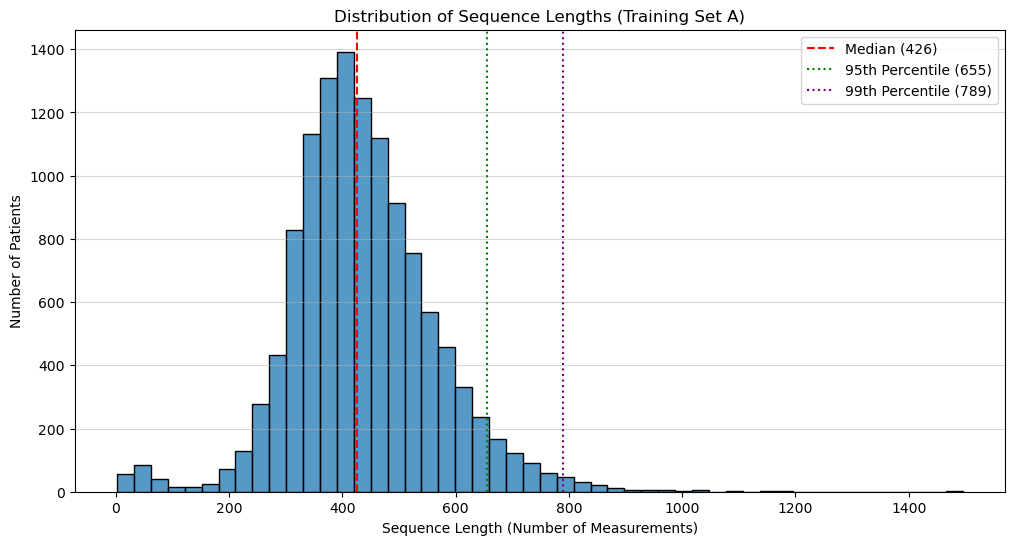

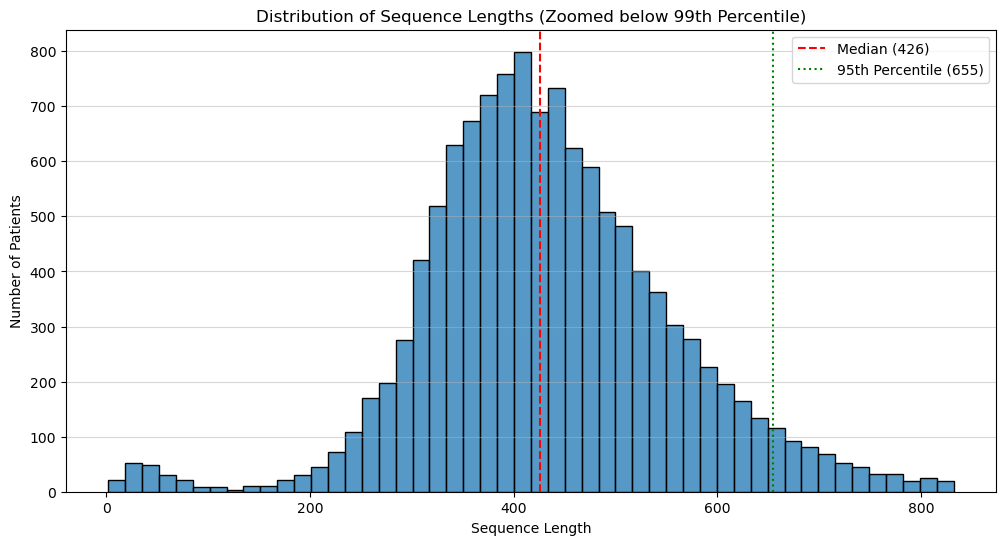

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sequence_lengths = [len(seq) for seq in train_sequences]
l = [len(seq) for seq in test_sequences]
x = [len(seq) for seq in val_sequences]
sequence_lengths.extend(l)
sequence_lengths.extend(x)
 

lengths_array = np.array(sequence_lengths)

# 2. Calculate Basic Statistics
min_len = np.min(lengths_array)
max_len = np.max(lengths_array)
avg_len = np.mean(lengths_array)
median_len = np.median(lengths_array) # 50th percentile

print("\n--- Sequence Length Statistics (Training Set A) ---")
print(f"Minimum Length: {min_len}")
print(f"Maximum Length: {max_len}")
print(f"Average Length: {avg_len:.2f}")
print(f"Median Length:  {median_len:.0f}")

# 3. Calculate Percentiles
percentiles_to_calculate = [50, 75, 90, 95, 98, 99, 99.5, 99.9]
percentile_values = np.percentile(lengths_array, percentiles_to_calculate)

print("\n--- Percentiles ---")
for p, val in zip(percentiles_to_calculate, percentile_values):
    print(f"{p}th Percentile: {val:.0f}")


p95_val = percentile_values[percentiles_to_calculate.index(95)]
p99_val = percentile_values[percentiles_to_calculate.index(99)]

# Suggest potential MAX_SEQ_LEN values (often rounded up slightly or to powers of 2/multiples of 8)
suggested_max_len_p95 = int(np.ceil(p95_val / 64.0)) * 64 if p95_val > 0 else 64
suggested_max_len_p99 = int(np.ceil(p99_val / 64.0)) * 64 if p99_val > 0 else 64

print(f"\nPotential MAX_SEQ_LEN values to consider (adjust based on resources):")
print(f"  - Based on ~95th percentile (rounded up to multiple of 64): {suggested_max_len_p95}")
print(f"  - Based on ~99th percentile (rounded up to multiple of 64): {suggested_max_len_p99}")
print(f"  - Common starting points: 512, 768, 1024")
print(f"  - Absolute Max (use only if necessary & feasible): {max_len}")

# 5. Visualization (Optional but Recommended)
print("\nGenerating histogram...")
plt.figure(figsize=(12, 6))
sns.histplot(lengths_array, bins=50, kde=False) # Use more bins if needed
plt.title('Distribution of Sequence Lengths (Training Set A)')
plt.xlabel('Sequence Length (Number of Measurements)')
plt.ylabel('Number of Patients')
# Add vertical lines for percentiles
plt.axvline(median_len, color='r', linestyle='--', label=f'Median ({median_len:.0f})')
plt.axvline(p95_val, color='g', linestyle=':', label=f'95th Percentile ({p95_val:.0f})')
plt.axvline(p99_val, color='purple', linestyle=':', label=f'99th Percentile ({p99_val:.0f})')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# Optional: Zoomed histogram if max length is very large
plt.figure(figsize=(12, 6))
sns.histplot(lengths_array[lengths_array <= suggested_max_len_p99], bins=50, kde=False) # Zoom below 99th percentile
plt.title('Distribution of Sequence Lengths (Zoomed below 99th Percentile)')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Patients')
plt.axvline(median_len, color='r', linestyle='--', label=f'Median ({median_len:.0f})')
plt.axvline(p95_val, color='g', linestyle=':', label=f'95th Percentile ({p95_val:.0f})')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
train_dataset = MedicalTimeSeriesDatasetTuple(train_sequences, train_labels, max_seq_len=MAX_SEQ_LEN)
val_dataset = MedicalTimeSeriesDatasetTuple(val_sequences, val_labels, max_seq_len=MAX_SEQ_LEN)
test_dataset = MedicalTimeSeriesDatasetTuple(test_sequences, test_labels, max_seq_len=MAX_SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Transformer model

class PositionalEncoding(nn.Module):
    """Standard sinusoidal positional encoding."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        self.pe: torch.Tensor

        return self.dropout(x)


class TimeSeriesTupleTransformer(nn.Module):
    def __init__(self, num_modalities, d_model, nhead, num_encoder_layers,
                 dim_feedforward, num_classes, dropout=0.1, max_seq_len=MAX_SEQ_LEN):
        super().__init__()
        self.d_model = d_model

        # Input embeddings
        self.modality_embedding = nn.Embedding(num_modalities, d_model, padding_idx=PAD_INDEX_Z)
        # Linear layers to project time and value to d_model
        # Alternatively, embed time/value differently if desired
        self.time_encoder_linear = nn.Linear(1, d_model // 3) # Allocate parts of d_model
        self.value_encoder_linear = nn.Linear(1, d_model // 3)
        self.modality_adjust_linear = nn.Linear(d_model, d_model - (d_model // 3)*2) # Adjust modality emb size

        # Combined projection (optional, could also just sum)
        # self.input_proj = nn.Linear(d_model, d_model) # If concatenating

        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len=max_seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        # Classifier head
        self.classifier = nn.Linear(d_model, num_classes)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.modality_embedding.weight.data.uniform_(-initrange, initrange)
        self.time_encoder_linear.weight.data.uniform_(-initrange, initrange)
        self.value_encoder_linear.weight.data.uniform_(-initrange, initrange)
        self.modality_adjust_linear.weight.data.uniform_(-initrange, initrange)
        # self.input_proj.weight.data.uniform_(-initrange, initrange)
        # self.input_proj.bias.data.zero_()
        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()

    def forward(self, t_seq, z_seq, v_seq, src_key_padding_mask):
        """
        Args:
            t_seq: (batch_size, seq_len) - Scaled time
            z_seq: (batch_size, seq_len) - Modality indices
            v_seq: (batch_size, seq_len) - Scaled values
            src_key_padding_mask: (batch_size, seq_len) - Bool mask (True=ignore)
        """
        # Embed inputs
        mod_emb = self.modality_embedding(z_seq) # (B, S, D)
        time_emb = self.time_encoder_linear(t_seq.unsqueeze(-1)) # (B, S, D//3)
        val_emb = self.value_encoder_linear(v_seq.unsqueeze(-1))  # (B, S, D//3)
        mod_emb_adj = self.modality_adjust_linear(mod_emb) # (B, S, D - 2*(D//3))


        # Combine embeddings - Concatenation is common
        # Ensure total dimension matches d_model
        combined_emb = torch.cat([time_emb, val_emb, mod_emb_adj], dim=-1) # (B, S, D)
        # combined_emb = self.input_proj(combined_emb) # Optional projection

        # Apply positional encoding (needs shape adjustment for default PyTorch PE)
        # Default PE expects (S, B, D)
        combined_emb = combined_emb.transpose(0, 1) # (S, B, D)
        combined_emb = self.pos_encoder(combined_emb)
        combined_emb = combined_emb.transpose(0, 1) # (B, S, D) - Back to batch_first

        # Transformer Encoder
        # src_key_padding_mask should be True for positions to ignore
        transformer_output = self.transformer_encoder(combined_emb, # (S, B, D)
                                                    src_key_padding_mask=~src_key_padding_mask) 

        # Pooling - Mean pool over non-padded elements
        # Need mask in float format for division
        mask_float = src_key_padding_mask.unsqueeze(-1).float() # (B, S, 1)
        masked_sum = (transformer_output * mask_float).sum(dim=1) # (B, D)
        num_valid = mask_float.sum(dim=1).clamp(min=1e-9) # (B, 1)
        pooled_output = masked_sum / num_valid # (B, D)

        # Classification
        logits = self.classifier(pooled_output) # (B, num_classes)
        return logits

    


In [92]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for t_seq, z_seq, v_seq, attn_mask, labels in tqdm(dataloader, desc="Training"):
        t_seq, z_seq, v_seq = t_seq.to(device), z_seq.to(device), v_seq.to(device)
        attn_mask, labels = attn_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(t_seq, z_seq, v_seq, attn_mask) # Pass correct mask polarity

        loss = criterion(logits.squeeze(-1), labels) # Squeeze if num_classes=1
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # Store predictions and labels for epoch metrics
        preds = torch.sigmoid(logits.squeeze(-1)).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    epoch_auc = roc_auc_score(all_labels, all_preds)
    epoch_auprc = average_precision_score(all_labels, all_preds)
    return avg_loss, epoch_auc, epoch_auprc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for t_seq, z_seq, v_seq, attn_mask, labels in tqdm(dataloader, desc="Evaluating"):
            t_seq, z_seq, v_seq = t_seq.to(device), z_seq.to(device), v_seq.to(device)
            attn_mask, labels = attn_mask.to(device), labels.to(device)

            logits = model(t_seq, z_seq, v_seq, attn_mask)
            loss = criterion(logits.squeeze(-1), labels)
            total_loss += loss.item()

            preds = torch.sigmoid(logits.squeeze(-1)).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    auc = roc_auc_score(all_labels, all_preds)
    auprc = average_precision_score(all_labels, all_preds)
    return avg_loss, auc, auprc





In [ ]:
model = TimeSeriesTupleTransformer(
        num_modalities=NUM_MODALITIES,
        d_model=D_MODEL,
        nhead=NHEAD,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        num_classes=NUM_CLASSES,
        dropout=DROPOUT,
        max_seq_len=MAX_SEQ_LEN
    ).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


num_positives = np.array(train_labels).sum()
num_negatives = len(train_labels) - num_positives
pos_weight_val = num_negatives / num_positives
pos_weight = torch.tensor([pos_weight_val], dtype= torch.float32,  device=DEVICE) # Wrap in tensor for BCEWithLogitsLoss

# # Loss Function with weighting
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


# --- Training Loop ---
best_val_auprc = -1.0

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    train_loss, train_auc, train_auprc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    print(f"Train Loss: {train_loss:.4f}, Train AuROC: {train_auc:.4f}, Train AuPRC: {train_auprc:.4f}")

    val_loss, val_auc, val_auprc = evaluate(model, val_loader, criterion, DEVICE)
    print(f"Val Loss:   {val_loss:.4f}, Val AuROC:   {val_auc:.4f}, Val AuPRC:   {val_auprc:.4f}")

    # Save best model based on validation AuPRC
    if val_auprc > best_val_auprc:
        print(f"Validation AuPRC improved ({best_val_auprc:.4f} -> {val_auprc:.4f}). Saving model...")
        best_val_auprc = val_auprc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

    scheduler.step(val_loss)
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}") # Optional: Track LR


# --- Final Evaluation on Test Set ---
print("\n--- Final Evaluation on Test Set ---")
# Load best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
test_loss, test_auc, test_auprc = evaluate(model, test_loader, criterion, DEVICE)
print("-------------------------------------------")
print(f"Test Loss:   {test_loss:.4f}")
print(f"Test AuROC:  {test_auc:.4f}")
print(f"Test AuPRC:  {test_auprc:.4f}")
print("-------------------------------------------")



TransformerForMeasurements(
  (modality_embedding): Embedding(41, 192, padding_idx=0)
  (time_encoder_linear): Linear(in_features=1, out_features=64, bias=True)
  (value_encoder_linear): Linear(in_features=1, out_features=64, bias=True)
  (modality_adjust_linear): Linear(in_features=192, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=512, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
        (linear2): Linear(in_features=512, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=Tr

Training: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


Train Loss: 1.2346, Train AuROC: 0.5061, Train AuPRC: 0.1389


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.52it/s]


Val Loss:   1.1920, Val AuROC:   0.6018, Val AuPRC:   0.2097
Validation AuPRC improved (-1.0000 -> 0.2097). Saving model...
Current LR: 0.000300

--- Epoch 2/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.40it/s]


Train Loss: 1.2014, Train AuROC: 0.5303, Train AuPRC: 0.1537


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.19it/s]


Val Loss:   1.2064, Val AuROC:   0.6070, Val AuPRC:   0.2148
Validation AuPRC improved (0.2097 -> 0.2148). Saving model...
Current LR: 0.000300

--- Epoch 3/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


Train Loss: 1.1944, Train AuROC: 0.5468, Train AuPRC: 0.1561


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.14it/s]


Val Loss:   1.1890, Val AuROC:   0.6261, Val AuPRC:   0.2301
Validation AuPRC improved (0.2148 -> 0.2301). Saving model...
Current LR: 0.000300

--- Epoch 4/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


Train Loss: 1.1890, Train AuROC: 0.5667, Train AuPRC: 0.1750


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.13it/s]


Val Loss:   1.1811, Val AuROC:   0.6649, Val AuPRC:   0.2660
Validation AuPRC improved (0.2301 -> 0.2660). Saving model...
Current LR: 0.000300

--- Epoch 5/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]


Train Loss: 1.1612, Train AuROC: 0.6176, Train AuPRC: 0.1976


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.59it/s]


Val Loss:   1.1435, Val AuROC:   0.6960, Val AuPRC:   0.2820
Validation AuPRC improved (0.2660 -> 0.2820). Saving model...
Current LR: 0.000300

--- Epoch 6/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.27it/s]


Train Loss: 1.0988, Train AuROC: 0.6858, Train AuPRC: 0.2430


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.18it/s]


Val Loss:   1.1509, Val AuROC:   0.7510, Val AuPRC:   0.3140
Validation AuPRC improved (0.2820 -> 0.3140). Saving model...
Current LR: 0.000300

--- Epoch 7/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


Train Loss: 1.0234, Train AuROC: 0.7444, Train AuPRC: 0.2905


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.06it/s]


Val Loss:   1.1949, Val AuROC:   0.7741, Val AuPRC:   0.3442
Validation AuPRC improved (0.3140 -> 0.3442). Saving model...
Current LR: 0.000300

--- Epoch 8/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


Train Loss: 0.9628, Train AuROC: 0.7811, Train AuPRC: 0.3233


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.50it/s]


Val Loss:   0.9991, Val AuROC:   0.7802, Val AuPRC:   0.3487
Validation AuPRC improved (0.3442 -> 0.3487). Saving model...
Current LR: 0.000300

--- Epoch 9/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.35it/s]


Train Loss: 0.9512, Train AuROC: 0.7919, Train AuPRC: 0.3385


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.04it/s]


Val Loss:   0.9923, Val AuROC:   0.7878, Val AuPRC:   0.3879
Validation AuPRC improved (0.3487 -> 0.3879). Saving model...
Current LR: 0.000300

--- Epoch 10/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


Train Loss: 0.9356, Train AuROC: 0.7956, Train AuPRC: 0.3525


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.39it/s]


Val Loss:   1.1742, Val AuROC:   0.7772, Val AuPRC:   0.3623
Current LR: 0.000300

--- Epoch 11/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


Train Loss: 0.9169, Train AuROC: 0.8063, Train AuPRC: 0.3847


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.00it/s]


Val Loss:   1.0055, Val AuROC:   0.7881, Val AuPRC:   0.3903
Validation AuPRC improved (0.3879 -> 0.3903). Saving model...
Current LR: 0.000300

--- Epoch 12/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


Train Loss: 0.8713, Train AuROC: 0.8287, Train AuPRC: 0.4275


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.13it/s]


Val Loss:   1.1608, Val AuROC:   0.7901, Val AuPRC:   0.3933
Validation AuPRC improved (0.3903 -> 0.3933). Saving model...
Current LR: 0.000300

--- Epoch 13/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.36it/s]


Train Loss: 0.8940, Train AuROC: 0.8183, Train AuPRC: 0.3907


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.43it/s]


Val Loss:   0.9986, Val AuROC:   0.7930, Val AuPRC:   0.3993
Validation AuPRC improved (0.3933 -> 0.3993). Saving model...
Current LR: 0.000030

--- Epoch 14/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


Train Loss: 0.8090, Train AuROC: 0.8555, Train AuPRC: 0.4731


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 47.69it/s]


Val Loss:   1.0957, Val AuROC:   0.7925, Val AuPRC:   0.4021
Validation AuPRC improved (0.3993 -> 0.4021). Saving model...
Current LR: 0.000030

--- Epoch 15/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


Train Loss: 0.7955, Train AuROC: 0.8587, Train AuPRC: 0.4869


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 47.86it/s]


Val Loss:   1.1039, Val AuROC:   0.7907, Val AuPRC:   0.3977
Current LR: 0.000030

--- Epoch 16/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.34it/s]


Train Loss: 0.7879, Train AuROC: 0.8626, Train AuPRC: 0.5076


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.48it/s]


Val Loss:   1.0704, Val AuROC:   0.7903, Val AuPRC:   0.3927
Current LR: 0.000030

--- Epoch 17/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


Train Loss: 0.8024, Train AuROC: 0.8571, Train AuPRC: 0.4973


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 47.87it/s]


Val Loss:   1.1027, Val AuROC:   0.7903, Val AuPRC:   0.3968
Current LR: 0.000003

--- Epoch 18/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


Train Loss: 0.7740, Train AuROC: 0.8670, Train AuPRC: 0.5021


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 47.91it/s]


Val Loss:   1.0931, Val AuROC:   0.7908, Val AuPRC:   0.3960
Current LR: 0.000003

--- Epoch 19/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


Train Loss: 0.7734, Train AuROC: 0.8652, Train AuPRC: 0.5047


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 47.93it/s]


Val Loss:   1.0933, Val AuROC:   0.7912, Val AuPRC:   0.3951
Current LR: 0.000003

--- Epoch 20/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


Train Loss: 0.7640, Train AuROC: 0.8702, Train AuPRC: 0.5173


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 47.83it/s]


Val Loss:   1.1054, Val AuROC:   0.7911, Val AuPRC:   0.3954
Current LR: 0.000003

--- Epoch 21/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


Train Loss: 0.7656, Train AuROC: 0.8674, Train AuPRC: 0.4983


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.07it/s]


Val Loss:   1.1125, Val AuROC:   0.7910, Val AuPRC:   0.3951
Current LR: 0.000000

--- Epoch 22/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.38it/s]


Train Loss: 0.7736, Train AuROC: 0.8645, Train AuPRC: 0.5007


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 47.74it/s]


Val Loss:   1.1128, Val AuROC:   0.7910, Val AuPRC:   0.3950
Current LR: 0.000000

--- Epoch 23/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


Train Loss: 0.7772, Train AuROC: 0.8652, Train AuPRC: 0.5121


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.58it/s]


Val Loss:   1.1116, Val AuROC:   0.7910, Val AuPRC:   0.3949
Current LR: 0.000000

--- Epoch 24/35 ---


Training: 100%|██████████| 125/125 [00:19<00:00,  6.31it/s]


Train Loss: 0.7724, Train AuROC: 0.8661, Train AuPRC: 0.5101


Evaluating: 100%|██████████| 125/125 [00:02<00:00, 48.13it/s]


Val Loss:   1.1116, Val AuROC:   0.7910, Val AuPRC:   0.3949
Current LR: 0.000000

--- Epoch 25/35 ---


Training:   6%|▌         | 7/125 [00:01<00:20,  5.87it/s]


KeyboardInterrupt: 